In [1]:
# -*- coding: utf-8 -*-
"""
Spyder Editor

This is a temporary script file.
"""

#__________________________________________________________________________________________________________________________________________




import os
import requests as req
import re
from bs4 import BeautifulSoup as bs
import time as ti
from fontTools.ttLib import TTFont
from PIL import Image, ImageDraw, ImageFont  #绘制图片
import numpy

import sys
import json
import base64

import pandas as pd


# 保证兼容python2以及python3
IS_PY3 = sys.version_info.major == 3
if IS_PY3:
    from urllib.request import urlopen
    from urllib.request import Request
    from urllib.error import URLError
    from urllib.parse import urlencode
    from urllib.parse import quote_plus
else:
    import urllib2
    from urllib import quote_plus
    from urllib2 import urlopen
    from urllib2 import Request
    from urllib2 import URLError
    from urllib import urlencode

# 防止https证书校验不正确
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

API_KEY = 'ut4yPeFsIQDLRyE0tAqVcl3Q'

SECRET_KEY = 'MACLNboqsb0Ya9HjMYy0lqeOSQPsiep0'


OCR_URL = "https://aip.baidubce.com/rest/2.0/ocr/v1/accurate_basic"

#imagePath = 'font\\3ba9acb4fdb2188c0c1ed654474de5dc2280.jpg'


"""  TOKEN start """
TOKEN_URL = 'https://aip.baidubce.com/oauth/2.0/token'


header = {
    "User-Agent" : "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/94.0.4606.71 Safari/537.36",
    "cookie" : "__mta=207992365.1633688795006.1634963461943.1634964221296.308; uuid_n_v=v1; _lxsdk_cuid=17c5f6f21d1c8-05a3492e39da2b-b7a1b38-1fa400-17c5f6f21d1c8; uuid=623441A0297F11EC8B5A61A0E822839EDCCED00AB21345B4A0A5FB8B9B8AB1F2; _lxsdk=623441A0297F11EC8B5A61A0E822839EDCCED00AB21345B4A0A5FB8B9B8AB1F2; __mta=213678763.1633688691565.1634826197915.1634870803473.277; _csrf=82edc8ef334e11ce473aa15e471a0c152dca89c05e9fcea1b8bd90b2d1234648; Hm_lvt_703e94591e87be68cc8da0da7cbd0be2=1634825421,1634870798,1634901514,1634963454; Hm_lpvt_703e94591e87be68cc8da0da7cbd0be2=1634964221; _lxsdk_s=17cab6a79f8-2a5-d50-eee%7C%7C11"
}

os.makedirs('font', exist_ok=True) #创建font文件存字体

regex_woff = re.compile("(?<=url\(').*\.woff(?='\))")
regex_text = re.compile('(?<=<span class="stonefont">).*?(?=</span>)')
regex_font = re.compile('(?<=&#x).{4}(?=;)')

listOfMCI = [] #二维数组，这个来存每个电影以及他们的票房编号对应的index
listOfBreak = [] #二维数组。这个来存来存每个电影以及他们的票房小数点
listOfLocalName = [] #二维数组。这个来存来存每个电影以及他们的woff文件地址
listofUnit = []

listOfName = [] #二维数组，存每个电影以及他们的名字

listOfDirector = []

listOfactors = []

listOfRating = []

listOfDuration = []

listOfType = []

listOfMoney = []

listOfIncome = []

"""
    获取token
"""
def fetch_token():
    params = {'grant_type': 'client_credentials',
              'client_id': API_KEY,
              'client_secret': SECRET_KEY}
    post_data = urlencode(params)
    if (IS_PY3):
        post_data = post_data.encode('utf-8')
    req = Request(TOKEN_URL, post_data)
    try:
        f = urlopen(req, timeout=5)
        result_str = f.read()
    except URLError as err:
        print(err)
    if (IS_PY3):
        result_str = result_str.decode()


    result = json.loads(result_str)

    if ('access_token' in result.keys() and 'scope' in result.keys()):
        if not 'brain_all_scope' in result['scope'].split(' '):
            print ('please ensure has check the  ability')
            exit()
        return result['access_token']
    else:
        print ('please overwrite the correct API_KEY and SECRET_KEY')
        exit()

"""
    读取文件
"""
def read_file(image_path):
    f = None
    try:
        f = open(image_path, 'rb')
        return f.read()
    except:
        print('read image file fail')
        return None
    finally:
        if f:
            f.close()


"""
    调用远程服务
"""
def request(url, data):
    req = Request(url, data.encode('utf-8'))
    has_error = False
    try:
        f = urlopen(req)
        result_str = f.read()
        if (IS_PY3):
            result_str = result_str.decode()
        return result_str
    except  URLError as err:
        print(err)

def getOcrResult(OCR_URL,imagePath):

    # 获取access token
    token = fetch_token()

    # 拼接通用文字识别高精度url
    image_url = OCR_URL + "?access_token=" + token

    text = ""

    # 读取测试图片
    file_content = read_file(imagePath)

    # 调用文字识别服务
    result = request(image_url, urlencode({'image': base64.b64encode(file_content)}))

    # 解析返回结果
    result_json = json.loads(result)
    for words_result in result_json["words_result"]:
        text = text + words_result["words"]

    return text


def downloads(url, localfn):
    with open(localfn, 'wb+') as sw:
        sw.write(req.get(url).content)
        
        
def link(url):
    res = req.get(url,headers = header)
    if res.status_code == 200:
        return bs(res.text,"lxml")
    return None

def linkOfHtml(url):
    res = req.get(url,headers = header)
    if res.status_code == 200:
        return res
    return None

for i in range(0,100,10):
    url = "https://maoyan.com/board/4?offset=" + str(i)
    movies = link(url).find_all("dd")
    for i in movies:
        #img = i.find("img",class_ = "board-img").get("data-src")
        num = i.find("i").text
        
        # listNum = [num,num]
        # listOfRating.append(listNum) 
        #listOfRating.append(num) 
        
        
        name = i.find("a").get("title")
        
        integer = i.find("i",class_= "integer").text
        fraction = i.find("i",class_= "fraction").text
        thisRating = integer + fraction
        listOfRating.append(thisRating)
        
        # listName = [num,name]
        # listOfName.append(listName)
        listOfName.append(name)
        
        actor = re.findall("主演：(.*)",i.find("p",class_ = "star").text)[0]
        
        # listActor = [num,actor]
        # listOfactors.append(listActor)
        listOfactors.append(actor)

        url1 = "https://maoyan.com" + i.find("p",class_ = "name").a.get("href")
        
        htmlOfmovie = linkOfHtml(url1)
        movie = bs(htmlOfmovie.text,"lxml")
        movieHtml = htmlOfmovie.text[:100000]
        
        ti.sleep(1)

        boss = movie.find("a",class_= "name").text.replace("\n","").replace(" ","")
        
        # listBoss = [num,boss]
        # listOfDirector.append(listBoss)
        listOfDirector.append(boss)
        
        # ifNoRating = -1
        # rating = movie.find_all(class_ ='attribute-item-content ellipsis')
        # for ind in range(0,len(rating)):
        #     if (rating[ind].text.find("本片")) != -1:
        #         ifNoRating = ind

        # if ifNoRating != -1:
        #     strRating = rating[ifNoRating].text
        #     startRating = strRating.find("【")
        #     endRating = strRating.find("】")
        #     strRating = strRating[startRating + 1:endRating]
        #     listOfRating.append(strRating)
        # else:
        #     listOfRating.append("暂无评级")
        
        
            
        
        test = movie.find_all('a',class_ = 'text-link')
        list1 = []
        for i in range(0,len(test)):
            list1.append(test[i].text)

        typeOfMovie = ""
        for i in range(0,len(list1)):
            typeOfMovie = typeOfMovie + list1[i][1:len(list1[i])-1] +','    
    
        typeOfMovie = typeOfMovie[0:len(typeOfMovie)-1] 
        
        # listType = [num,typeOfMovie]
        # listOfType.append(listType)
        listOfType.append(typeOfMovie)
        
        # typeOfMovie = []
        # for i in range(0,len(list1)):
        #     typeOfMovie = typeOfMovie + list1[i][1:len(list1[i])-1] +','    
    
        # typeOfMovie = typeOfMovie[0:len(typeOfMovie)-1] 
        
        # # listType = [num,typeOfMovie]
        # # listOfType.append(listType)
        # listOfType.append(typeOfMovie)
        
            
        test1 = movie.find_all('li',class_ = 'ellipsis')[1].text
        
        startOfDuration = test1.find("/") + 2
        endOfDuration = test1.find("分钟")
        
        duration = test1[startOfDuration:endOfDuration]
        
        # listDuration = [num,duration]
        # listOfDuration.append(listDuration)
        listOfDuration.append(duration)
        
        ms = regex_text.findall(movieHtml)
        print("-------------------------------------")
        if len(ms) < 3:
            money = "暂无"
        else:
            
            codeOfIncome = ms[2]
            
            totalMoney = movie.find_all(class_ ='film-mbox-item')
            if len(totalMoney) == 3:
                scopeTotalMoney = totalMoney[2].text# 如果是3
                money = scopeTotalMoney[1:(scopeTotalMoney.find("累计票房") - 1)]
                unitOfMoney = scopeTotalMoney[(scopeTotalMoney.find("累计票房")):(scopeTotalMoney.find("累计票房") + 7)]
                money = money +  unitOfMoney

            elif len(totalMoney) == 2:
                scopeTotalMoney = totalMoney[1].text# 如果是2
                money = scopeTotalMoney[1:(scopeTotalMoney.find("累计票房") - 1)]
                unitOfMoney = scopeTotalMoney[(scopeTotalMoney.find("累计票房")):(scopeTotalMoney.find("累计票房") + 7)]
                money = money +  unitOfMoney    
            else:
                money = "请重做"
                
        listMoney = [num,money]
            
        listOfMoney.append(listMoney)
                
        if money == "暂无累计票房(万)":
            breakPoint = codeOfIncome.find(".")
    
            if breakPoint != -1:
                breakPoint = breakPoint / 8
                    
            listBreak = [num,breakPoint]
            listOfBreak.append(listBreak)
                
            woff = regex_woff.search(movieHtml).group()
            wofflink = 'http:' + woff
            localname = 'font\\' + os.path.basename(wofflink)
            listLocal = [num,localname]
            listOfLocalName.append(listLocal)
                
            if not os.path.exists(localname):
                downloads(wofflink, localname)
            font = TTFont(localname)
            listOfWoffCode = font.getGlyphOrder()[2:]
            unit = movie.find('span',class_ = 'unit').text
            listUnit = [num,unit]
            listofUnit.append(listUnit)
                
            listOfCode = []
                
            ms2 = regex_font.findall(codeOfIncome)
    
            for m in ms2:
                m = f'uni{m.upper()}'

                for i in range(0,len(listOfWoffCode)):
                    if m == listOfWoffCode[i]:
                        listOfCode.append(i)
            listMCI = [num,listOfCode]            
            listOfMCI.append(listMCI)            
        
        a = {
            "片名" : name,
            "排名" : num,
            "演员" : actor,
            "导演" : boss,
            "类型" : typeOfMovie,
            "时长(分钟)" : duration,
            "累计票房" : money
        }

        print(a)
# print("-------------------------------------------")
# print(listOfName)
# print("-------------------------------------------")
# print(listOfMCI)
# print("-------------------------------------------")
# print(listOfBreak)
# print("-------------------------------------------")
# print(listOfLocalName)
# print("-------------------------------------------")
# print(listofUnit) 
# print("-------------------------------------------")
# print(listOfName)        
# print("-------------------------------------------")
# print(listOfDirector)     
# print("-------------------------------------------")
# print(listOfactors)  
print("-------------------------------------------")
print(listOfRating)              
print("-------------------------------------------")
# print(len(listOfRating))
# print(listOfDuration)  
# print("-------------------------------------------")
# print(listOfType) 
# print("-------------------------------------------")
# print(listOfMoney) 
print(len(listOfMoney))
for i in range(0,len(listOfLocalName)):
    font = TTFont(listOfLocalName[i][1])  # 打开文件
    #print(listOfLocalName[i][1])
    codeList = font.getGlyphOrder()[2:]
    im = Image.new("RGB", (1800, 1000), (255, 255, 255))
    dr = ImageDraw.Draw(im)
    font = ImageFont.truetype(listOfLocalName[i][1], 40)
    count = 1
    arrayList = numpy.array_split(codeList,count)   #将列表切分成15份，以便于在图片上分行显示
    for t in range(count):
        newList = [i.replace("uni", "\\u") for i in arrayList[t]]
        text = "".join(newList)
        text = text.encode('utf-8').decode('unicode_escape')
        dr.text((0, 50 * t), text, font=font, fill="#000000")
        im.save(listOfLocalName[i][1][0:41] + ".jpg")
        
    numberList = getOcrResult(OCR_URL,listOfLocalName[i][1][0:41] + ".jpg")
    ti.sleep(1)
    print(numberList)
    listIndex = listOfMCI[i][1]
    
    # for a in range(0:len(numberList)):
    #     for b in range(0:len(listIndex)):
    #         if listIndex[j] == 
    strNumber = ""
    for a in range(0,len(listIndex)):
        strNumber = strNumber + numberList[listIndex[a]:listIndex[a] + 1]

                
    strUnit = listofUnit[i][1]
    strMoney = strNumber + strUnit
    print(strMoney)
    indexN = int(listOfLocalName[i][0])
    print(indexN)
    listOfMoney[indexN-1][1] = strMoney
    
print("-------------------------------------------")
print(listOfMoney)

for i in range(0,len(listOfMoney)):
    listOfIncome.append(listOfMoney[i][1])

scraped_data = pd.DataFrame({'Title': listOfName, 'director': listOfDirector, 'actors': listOfactors, 'Rating': listOfRating, 'income': listOfIncome, 'Duration': listOfDuration, 'Type': listOfType})

scraped_data.to_csv('./jiayu.jian1716852.csv',encoding='utf_8_sig')        
                



-------------------------------------
{'片名': '哪吒之魔童降世', '排名': '1', '演员': '吕艳婷,囧森瑟夫,瀚墨', '导演': '饺子', '类型': '动画,喜剧,奇幻', '时长(分钟)': '110', '累计票房': '503570累计票房(万)'}
-------------------------------------
{'片名': '我不是药神', '排名': '2', '演员': '徐峥,周一围,王传君', '导演': '文牧野', '类型': '剧情,喜剧', '时长(分钟)': '117', '累计票房': '310002累计票房(万)'}
-------------------------------------
{'片名': '肖申克的救赎', '排名': '3', '演员': '蒂姆·罗宾斯,摩根·弗里曼,鲍勃·冈顿', '导演': '弗兰克·德拉邦特', '类型': '剧情,犯罪', '时长(分钟)': '142', '累计票房': '暂无'}
-------------------------------------
{'片名': '海上钢琴师', '排名': '4', '演员': '蒂姆·罗斯,比尔·努恩 ,克兰伦斯·威廉姆斯三世', '导演': '朱塞佩·托纳多雷', '类型': '剧情,爱情,音乐', '时长(分钟)': '126', '累计票房': '14376累计票房(万)'}


AttributeError: 'NoneType' object has no attribute 'text'

<ipython-input-2-25a0475a95dd>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.income[i] = data.income[i][0:endIncome]
<ipython-input-2-25a0475a95dd>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.income[i] = strNum
<ipython-input-2-25a0475a95dd>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newdata['income'] = newdata['income'].astype('int64')


Type      object
income     int64
dtype: object
      0    1    2    3  Rating
0    动画   喜剧   奇幻  NaN     9.6
1    剧情   喜剧  NaN  NaN     9.6
3    剧情   爱情   音乐  NaN     9.3
4    剧情   喜剧   传记  NaN     9.5
5    剧情   犯罪  NaN  NaN     8.1
6    战争   剧情   爱情  NaN     9.3
7    剧情   爱情  NaN  NaN     9.4
10   动作   悬疑   惊悚   科幻     9.0
15   剧情   爱情  NaN  NaN     8.9
16   动画   冒险   奇幻   家庭     9.3
17   剧情   科幻   冒险  NaN     9.3
18   剧情  NaN  NaN  NaN     9.3
20   剧情   奇幻   冒险  NaN     9.0
21   喜剧   动作   家庭  NaN     9.8
22   剧情   爱情  NaN  NaN     9.3
23   动画   冒险   家庭  NaN     9.6
28   剧情   家庭   传记  NaN     9.3
29   剧情   家庭   历史  NaN     9.0
31   动画   冒险   奇幻   家庭     9.2
33   剧情   爱情   灾难  NaN     9.4
34   剧情   犯罪  NaN  NaN     8.6
35   爱情   动画   奇幻  NaN     9.2
36   犯罪   悬疑   惊悚  NaN     9.4
38   剧情  NaN  NaN  NaN     8.8
39   剧情   喜剧   冒险  NaN     9.1
40   剧情  NaN  NaN  NaN     8.7
41   剧情   犯罪  NaN  NaN     9.1
43   动作   冒险   科幻  NaN     9.0
47   剧情   悬疑  NaN  NaN     9.0
50   剧情   动作   悬疑   惊悚

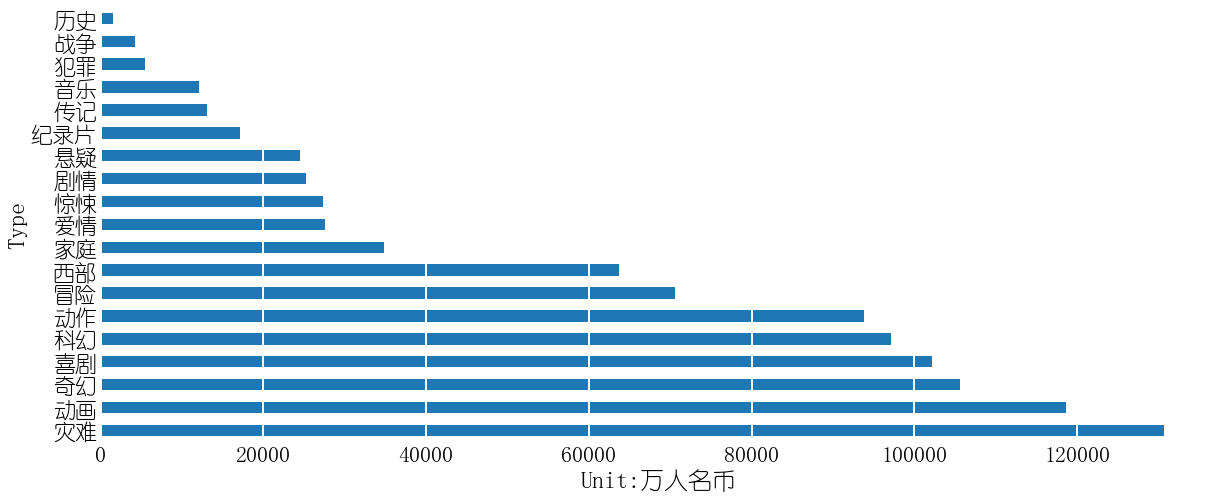

In [2]:
import numpy as np # imports a fast numerical programming library
import scipy as sp #imports stats functions, amongst other things
import matplotlib as mpl # this actually imports matplotlib
import matplotlib.cm as cm #allows us easy access to colormaps
import matplotlib.pyplot as plt #sets up plotting under plt
import pandas as pd #lets us handle data as dataframes
import seaborn as sns

import matplotlib
matplotlib.rc("font",family='YouYuan')

#sets up pandas table display
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

data = pd.read_csv('./jiayu.jian1716852.csv')

# data=data.rename(columns={"Unnamed: 0":"index"})
# print(data.shape)

# data['Type'] = data.Type.apply(lambda x: x.split()[0])
# print(data['Type'])
# print(type(data['Type']))

# print(data.dtypes)

# data[['Title','director']]
# print(data[['Title','director']])
#print(data.Type[99])

for i in range(0,100):
    if (data.income[i].find("累计票房(万)")) != -1:
        endIncome = data.income[i].find("累计票房(万)")
        data.income[i] = data.income[i][0:endIncome]
        
    elif (data.income[i].find("万美元")) != -1:
        endIncome = data.income[i].find("万美元")
        strNum = data.income[i][0:endIncome]
        numincome = int(int(strNum) * 6.3874)
        strNum = str(numincome)
        data.income[i] = strNum
                


newdata = data[data.income != '暂无'] 
del newdata['Unnamed: 0']
newdata['income'] = newdata['income'].astype('int64')       

#newdata.Type = newdata.Type.apply(lambda x: x.split()[0])
allType = newdata.Type.str.split(',').apply(pd.Series)
allType['income'] = newdata['income']
#print(allType)

#for i in range(0,allType.shape):
newAllType = allType[[0,'income']]

newAllType1 = allType[[1,'income']]    

newAllType1=newAllType1.rename(columns={1:0})

newAllType = pd.concat([newAllType, newAllType1])

newAllType1 = allType[[2,'income']]  

newAllType1=newAllType1.rename(columns={2:0})

newAllType = pd.concat([newAllType, newAllType1])

newAllType1 = allType[[3,'income']]  

newAllType1=newAllType1.rename(columns={3:0})

newAllType = pd.concat([newAllType, newAllType1])

newAllType = newAllType[newAllType.income != '暂无'] 

newAllType = newAllType.dropna()

newAllType=newAllType.rename(columns={0:'Type'})

print(newAllType.dtypes)

typeIncome = newAllType.groupby('Type').income.mean()

typeIncome = typeIncome.sort_values(ascending = False)



#print(typeIncome)
allType = newdata.Type.str.split(',').apply(pd.Series)
allType['Rating'] = newdata['Rating']
print(allType)
newAllType = allType[[0,'Rating']]

newAllType1 = allType[[1,'Rating']]    

newAllType1=newAllType1.rename(columns={1:0})

newAllType = pd.concat([newAllType, newAllType1])

newAllType1 = allType[[2,'Rating']]  

newAllType1=newAllType1.rename(columns={2:0})

newAllType = pd.concat([newAllType, newAllType1])

newAllType1 = allType[[3,'Rating']]  

newAllType1=newAllType1.rename(columns={3:0})

newAllType = pd.concat([newAllType, newAllType1])

newAllType = newAllType.dropna()

newAllType=newAllType.rename(columns={0:'Type'})

#print(newAllType.dtypes)

typeRating = newAllType.groupby('Type').Rating.mean()

typeRating = typeRating.sort_values(ascending = False) 
#print(typeRating)      

# plt.figure(figsize=(4, 8))

# with sns.plotting_context("poster"):
#     ax = plt.gca()
#     typeIncome.plot(kind="barh")
#     plt.grid(axis = 'x', color ='white', linestyle='-')
#     ax.tick_params(axis='both', which='both',length=0)
#     sns.despine(left=True, bottom=True)

#typeIncome.plot(kind='bar',figsize=(14,6))

plt.figure(figsize=(20, 8))

with sns.plotting_context("poster"):
    ax = plt.gca()
    typeIncome.plot(kind="barh")
    plt.grid(axis = 'x', color ='white', linestyle='-')
    ax.tick_params(axis='both', which='both',length=0)
    sns.despine(left=True, bottom=True)
    
plt.xlabel("Unit:万人名币")
plt.savefig('1.pdf')

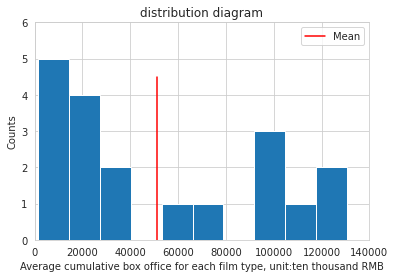

In [3]:
with sns.axes_style("whitegrid"):
    typeIncome.hist(bins=10)
    plt.xlim(0, 140000)
    plt.ylim([0, 6])
    avrage = typeIncome.mean()
    plt.axvline(avrage, 0, 0.75, color='r', label='Mean')
    plt.xlabel("Average cumulative box office for each film type, unit:ten thousand RMB")
    plt.ylabel("Counts")
    plt.title("distribution diagram")
    plt.legend()
    
plt.savefig('2.pdf')    

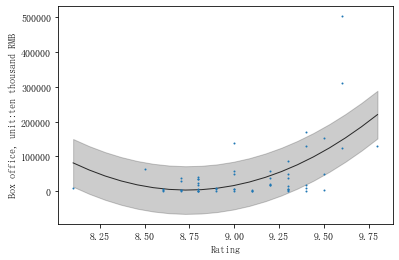

In [4]:
x = newdata.Rating
y = newdata.income
params = np.polyfit(x, y, 2)
xp = np.linspace(x.min(), x.max(), 20)
yp = np.polyval(params, xp)
plt.plot(xp, yp, 'k', alpha=0.8, linewidth=1)
plt.plot(newdata.Rating, newdata.income, 'o', markersize=1, alpha=1)
sig = np.std(y - np.polyval(params, x))
plt.fill_between(xp, yp - sig, yp + sig, 
                 color='k', alpha=0.2)
plt.ylabel("Box office, unit:ten thousand RMB")
plt.xlabel("Rating")
plt.savefig('3.pdf')

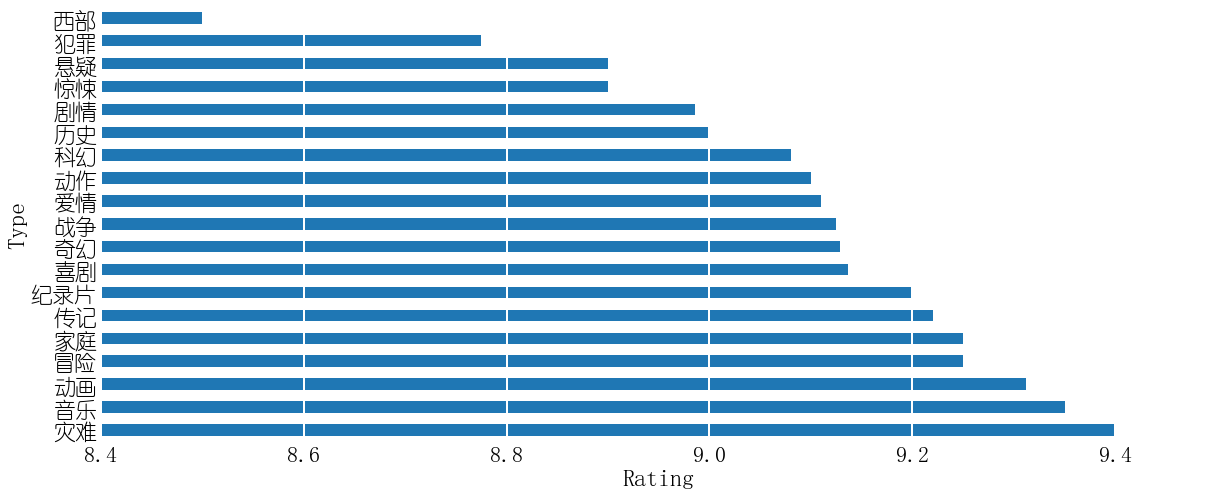

In [5]:
plt.figure(figsize=(20, 8))

with sns.plotting_context("poster"):
    plt.xlim(8.4, 9.5)
    
    ax = plt.gca()
    typeRating.plot(kind="barh")
    plt.grid(axis = 'x', color ='white', linestyle='-')
    ax.tick_params(axis='both', which='both',length=0)
    sns.despine(left=True, bottom=True)
    
plt.xlabel("Rating")
plt.savefig('4.pdf')

<ipython-input-6-7532f0d262f3>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.income[i] = data.income[i][0:endIncome]
<ipython-input-6-7532f0d262f3>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.income[i] = strNum
<ipython-input-6-7532f0d262f3>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newdata['income'] = newdata['income'].astype('int64')


Type      object
income     int64
dtype: object
             income
Type               
灾难    130615.000000
动画    118632.625000
奇幻    105615.571429
喜剧    102177.727273
科幻     97100.000000
动作     93740.875000
冒险     70630.750000
西部     63675.000000
家庭     34832.500000
爱情     27546.600000
惊悚     27307.166667
剧情     25251.571429
悬疑     24529.714286
纪录片    17062.000000
传记     13041.400000
音乐     12141.500000
犯罪      5434.500000
战争      4254.500000
历史      1488.000000
        Rating
Type          
灾难    9.400000
音乐    9.350000
动画    9.312500
冒险    9.250000
家庭    9.250000
传记    9.220000
纪录片   9.200000
喜剧    9.136364
奇幻    9.128571
战争    9.125000
爱情    9.110000
动作    9.100000
科幻    9.080000
历史    9.000000
剧情    8.985714
惊悚    8.900000
悬疑    8.900000
犯罪    8.775000
西部    8.500000
             income    Rating  typeCode
Type                                   
灾难    130615.000000  9.400000       0.5
动画    118632.625000  9.312500       0.5
奇幻    105615.571429  9.128571       0.5
喜剧    102177.7272

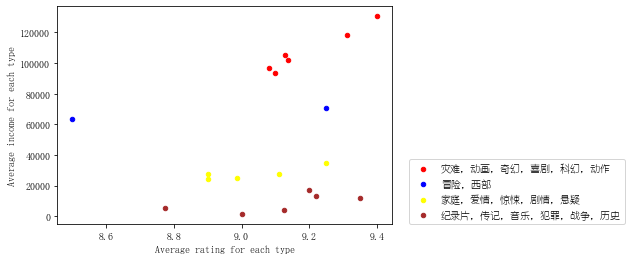

In [6]:
import numpy as np # imports a fast numerical programming library
import scipy as sp #imports stats functions, amongst other things
import matplotlib as mpl # this actually imports matplotlib
import matplotlib.cm as cm #allows us easy access to colormaps
import matplotlib.pyplot as plt #sets up plotting under plt
import pandas as pd #lets us handle data as dataframes
import seaborn as sns

import matplotlib
matplotlib.rc("font",family='YouYuan')

#sets up pandas table display
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

data = pd.read_csv('./jiayu.jian1716852.csv')

# data=data.rename(columns={"Unnamed: 0":"index"})
# print(data.shape)

# data['Type'] = data.Type.apply(lambda x: x.split()[0])
# print(data['Type'])
# print(type(data['Type']))

# print(data.dtypes)

# data[['Title','director']]
# print(data[['Title','director']])
#print(data.Type[99])

for i in range(0,100):
    if (data.income[i].find("累计票房(万)")) != -1:
        endIncome = data.income[i].find("累计票房(万)")
        data.income[i] = data.income[i][0:endIncome]
        
    elif (data.income[i].find("万美元")) != -1:
        endIncome = data.income[i].find("万美元")
        strNum = data.income[i][0:endIncome]
        numincome = int(int(strNum) * 6.3874)
        strNum = str(numincome)
        data.income[i] = strNum
                


newdata = data[data.income != '暂无'] 
del newdata['Unnamed: 0']
newdata['income'] = newdata['income'].astype('int64')       

#newdata.Type = newdata.Type.apply(lambda x: x.split()[0])
allType = newdata.Type.str.split(',').apply(pd.Series)
allType['income'] = newdata['income']
#print(allType)

#for i in range(0,allType.shape):
newAllType = allType[[0,'income']]

newAllType1 = allType[[1,'income']]    

newAllType1=newAllType1.rename(columns={1:0})

newAllType = pd.concat([newAllType, newAllType1])

newAllType1 = allType[[2,'income']]  

newAllType1=newAllType1.rename(columns={2:0})

newAllType = pd.concat([newAllType, newAllType1])

newAllType1 = allType[[3,'income']]  

newAllType1=newAllType1.rename(columns={3:0})

newAllType = pd.concat([newAllType, newAllType1])

newAllType = newAllType[newAllType.income != '暂无'] 

newAllType = newAllType.dropna()

newAllType=newAllType.rename(columns={0:'Type'})

print(newAllType.dtypes)

typeIncome = newAllType.groupby('Type').income.mean()

typeIncome = typeIncome.sort_values(ascending = False)





typeIncome = typeIncome.to_frame()

print(typeIncome)
allType = newdata.Type.str.split(',').apply(pd.Series)
allType['Rating'] = newdata['Rating']
#print(allType)
newAllType = allType[[0,'Rating']]

newAllType1 = allType[[1,'Rating']]    

newAllType1=newAllType1.rename(columns={1:0})

newAllType = pd.concat([newAllType, newAllType1])

newAllType1 = allType[[2,'Rating']]  

newAllType1=newAllType1.rename(columns={2:0})

newAllType = pd.concat([newAllType, newAllType1])

newAllType1 = allType[[3,'Rating']]  

newAllType1=newAllType1.rename(columns={3:0})

newAllType = pd.concat([newAllType, newAllType1])

newAllType = newAllType.dropna()

newAllType=newAllType.rename(columns={0:'Type'})

#print(newAllType.dtypes)

typeRating = newAllType.groupby('Type').Rating.mean()

typeRating = typeRating.sort_values(ascending = False) 

typeRating = typeRating.to_frame()

print(typeRating)    

typeIncome['Rating'] = typeRating['Rating']


typeCode = [0.5,0.5,0.5,0.5,0.5,0.5,1,1,2,2,2,2,2,3,3,3,3,3,3]
typeIncome['typeCode'] = typeCode
print(typeIncome)
#g = sns.FacetGrid(typeIncome,  hue="typeCode")
#g.map(plt.scatter, "income", "Rating", alpha=0.5, s=10)
#plt.savefig('5.pdf')
print(typeIncome.dtypes)
df1 = typeIncome[typeIncome.typeCode == 0.5]
df2 = typeIncome[typeIncome.typeCode == 1]
df3 = typeIncome[typeIncome.typeCode == 2]
df4 = typeIncome[typeIncome.typeCode == 3]
# 气泡值大小
#s = list(typeIncome.typeCode * 6)
# print(s)
# 气泡颜色
#color = np.random.rand(len(list(typeIncome.typeCode)))
# print(color)
# 绘制
s1 = plt.scatter(x=list(df1.Rating),y=list(df1.income),s=20,c='r')
s2 = plt.scatter(x=list(df2.Rating),y=list(df2.income),s=20,c='blue')
s3 = plt.scatter(x=list(df3.Rating),y=list(df3.income),s=20,c='yellow')
s4 = plt.scatter(x=list(df4.Rating),y=list(df4.income),s=20,c='brown')

#plt.grid(True)
plt.legend((s1,s2,s3,s4), ("灾难，动画，奇幻，喜剧，科幻，动作", "冒险，西部", "家庭，爱情，惊悚，剧情，悬疑","纪录片，传记，音乐，犯罪，战争，历史"), bbox_to_anchor=(1.05, 0), loc=3, borderaxespad=0)
plt.xlabel("Average rating for each type")
plt.ylabel("Average income for each type")
plt.savefig('5.pdf',bbox_inches = 'tight') 
